In [93]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [94]:
import sys
sys.path.append('/data/tjarniko/mocsy')
import mocsy

import netCDF4 as nc
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import gsw
import cmocean as cm
import arrow
import warnings
warnings.filterwarnings('ignore')

In [95]:
## retrieve days as arrow objects

start ='2015-01-01'
end ='2015-12-31'

start_run = arrow.get(start)
end_run = arrow.get(end)

arrow_array = []

for r in arrow.Arrow.span_range('day', start_run, end_run):
    arrow_array.append(r)

In [96]:
#retreive present day DIC and salinity
presday_DIC = np.zeros([365,40,950])
presday_TA = np.zeros([365,40,950])
presday_sal = np.zeros([365,40,950])

for i in range(0,365):

    tdate = arrow_array[i][0]
    #ymd = tdate.format('YYYY')
    yy = tdate.format('YYYY')
    mm = tdate.format('MM')
    dd = tdate.format('DD')
    ymd = f'y{yy}m{mm}d{dd}.nc'

#     if i%60 == 0:
#         #print(ymd)
    presday = nc.Dataset(f'/results/forcing/LiveOcean/boundary_conditions/LiveOcean_v201905_{ymd}')
    presday_DIC[i,:,:] = presday['DIC'][0,:,0,:]
    presday_TA[i,:,:] = presday['TA'][0,:,0,:]
    presday_sal[i,:,:] = presday['vosaline'][0,:,0,:]
    presday.close()



In [97]:
oldPI_DIC = np.zeros([365,40,950])
for i in range(0,365):

    tdate = arrow_array[i][0]
    #ymd = tdate.format('YYYY')
    yy = tdate.format('YYYY')
    mm = tdate.format('MM')
    dd = tdate.format('DD')
    ymd = f'y{yy}m{mm}d{dd}.nc'

    #if i%60 == 0:
        #print(ymd)
    oldPI = nc.Dataset(f'./PREIND_BCCOND/PREIND_BC_v201905_{ymd}')
    oldPI_DIC[i,:,:] = oldPI['DIC'][0,:,0,:]      
    oldPI.close()



In [99]:
#LO_AOUmethod_stoicCO_diseq_allup_y2015m12d29_preind_DIC.nc

newPI_DIC = np.zeros([365,40,950])
newPI_sigma0 = np.zeros([365,40,950])
for i in range(0,365):

    tdate = arrow_array[i][0]
    yy = tdate.format('YYYY')
    mm = tdate.format('MM')
    dd = tdate.format('DD')
    ymd = f'y{yy}m{mm}d{dd}'

#     if i%60 == 0:
        #print(ymd)
    newPI = nc.Dataset(f'./preind_DIC/LO_AOUmethod_stoicCO_diseq_allup_{ymd}_preind_DIC.nc')
   # print(newPI)
    newPI_DIC[i,:,:] = newPI['preindustrial_DIC']['preind_dic'][:,:] 
    newPI_sigma0[i,:,:] = newPI['preindustrial_DIC']['sigma0'][:,:] 
    newPI.close()

In [100]:
newPI_DIC_sigadj = np.copy(newPI_DIC)
newPI_DIC_sigadj[newPI_sigma0<=25] = presday_DIC[newPI_sigma0<=25]-50

In [101]:
## averages

newPI_DIC_monthly = np.zeros([12,40,950])
newPI_DIC_sigadj_monthly = np.zeros([12,40,950])
oldPI_DIC_monthly = np.zeros([12,40,950])
presday_DIC_monthly = np.zeros([12,40,950])
presday_TA_monthly = np.zeros([12,40,950])
newPI_sigma0_monthly = np.zeros([12,40,950])


for i in range(0,12):
    
    newPI_DIC_sigadj_monthly[i,:,:] = \
        np.nanmean(newPI_DIC_sigadj[(i*30):((i+1)*30),:,:], axis = 0)
    newPI_DIC_monthly[i,:,:] = \
        np.nanmean(newPI_DIC[(i*30):((i+1)*30),:,:], axis = 0)
    oldPI_DIC_monthly[i,:,:] = \
        np.nanmean(oldPI_DIC[(i*30):((i+1)*30),:,:], axis = 0)
    presday_DIC_monthly[i,:,:] = \
        np.nanmean(presday_DIC[(i*30):((i+1)*30),:,:], axis = 0)
    presday_TA_monthly[i,:,:] = \
        np.nanmean(presday_TA[(i*30):((i+1)*30),:,:], axis = 0)
    newPI_sigma0_monthly[i,:,:] = \
        np.nanmean(newPI_sigma0[(i*30):((i+1)*30),:,:], axis = 0)

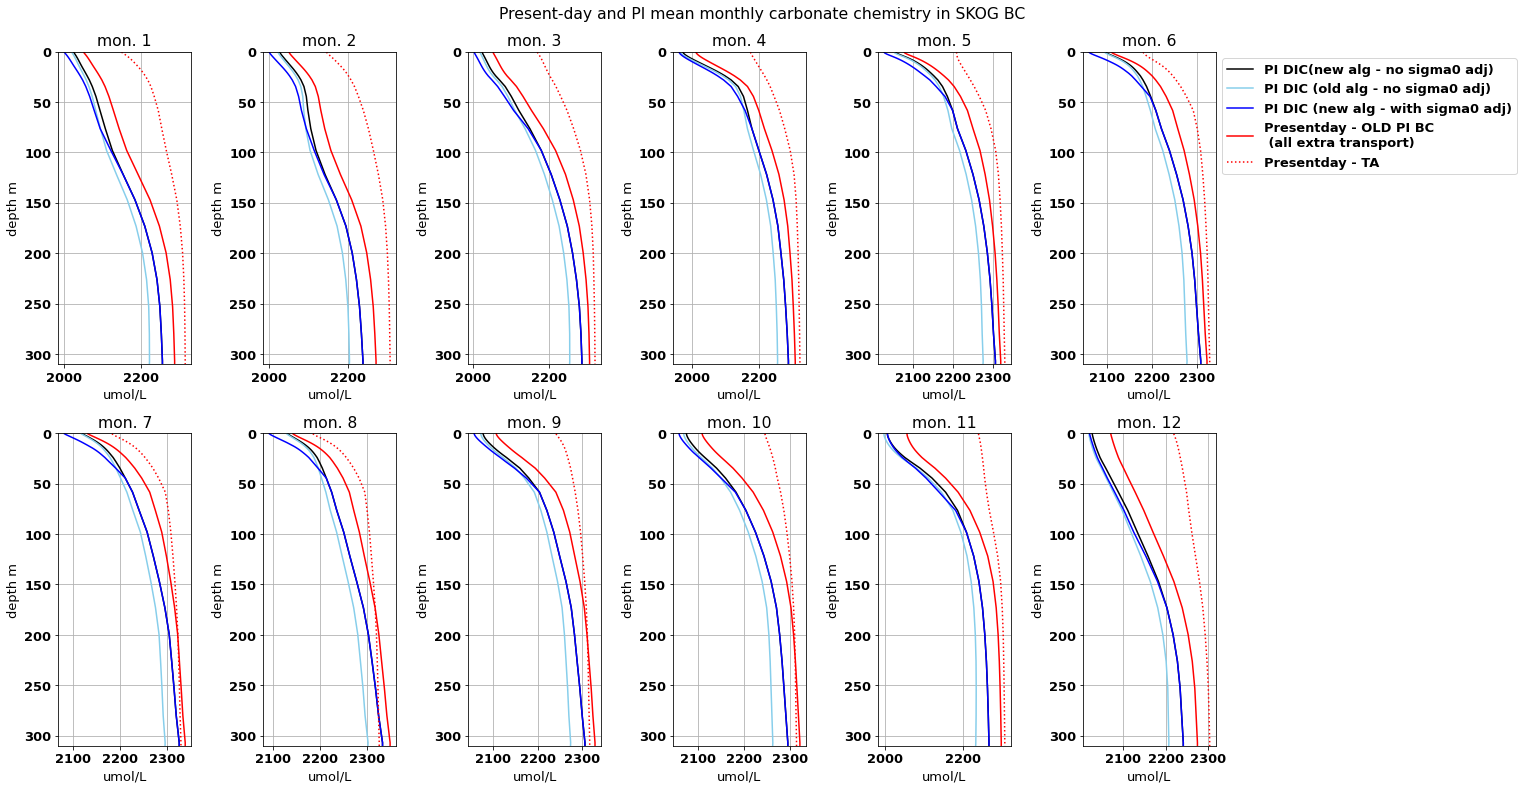

In [123]:
plt.rcParams.update({'font.size': 13})
font = {'family' : 'normal',
'weight' : 'bold',
'size'   : 13}

plt.rc('font', **font)


w = nc.Dataset('/data/tjarniko/MEOPAR/grid/mesh_mask201702.nc')

depths = w['gdept_1d'][0,:]

fact = 0.8
fig, axs = plt.subplots(2,6, figsize=(26.7*fact, 14*fact), facecolor='w', edgecolor='k')
#plt.xticks(rotation=70)

axs = axs.ravel()

for i in range(0,12):

    axs[i].plot(np.nanmean(newPI_DIC_monthly[i,:,:],axis = 1), \
                depths, color = 'k', \
                linestyle = '-', label = 'PI DIC(new alg - no sigma0 adj)')
    axs[i].plot(np.nanmean(oldPI_DIC_monthly[i,:,:],axis = 1), \
                depths, color = 'skyblue', \
                linestyle = '-', label = 'PI DIC (old alg - no sigma0 adj)')        
    axs[i].plot(np.nanmean(newPI_DIC_sigadj_monthly[i,:,:],axis = 1), \
                depths, color = 'b', \
                linestyle = '-', label = 'PI DIC (new alg - with sigma0 adj)')
    axs[i].plot(np.nanmean(presday_DIC_monthly[i,:,:],axis = 1), \
                depths, color = 'r', \
                linestyle = '-', label = 'Presentday - OLD PI BC \n (all extra transport)')
    axs[i].plot(np.nanmean(presday_TA_monthly[i,:,:],axis = 1), \
                depths, color = 'r', \
                linestyle = ':', label = 'Presentday - TA')
   # plt.xticks(rotation=70) 
for i in range(0,12):
    axs[i].grid();
    axs[i].set_ylim([0,310])
    axs[i].invert_yaxis()
    axs[i].set_title(f'mon. {i+1}')
    axs[i].set_ylabel('depth m')
    axs[i].set_xlabel('umol/L')

    
axs[5].legend(bbox_to_anchor = [1, 1])    
plt.suptitle('Present-day and PI mean monthly carbonate chemistry in SKOG BC')
plt.tight_layout()

In [103]:
intrusion = presday_DIC-newPI_DIC

In [104]:
np.min(intrusion)
print('isopycnals not represented (yearround)')
newPI_sigma0

sigmabands = np.arange(20,27,0.1)

max_int_yearround = np.zeros_like(sigmabands)
min_int_yearround = np.zeros_like(sigmabands)
mean_int_yearround = np.zeros_like(sigmabands)

#np.nanm(intrusion[(newPI_sigma0>25) & (newPI_sigma0<25.1)])

for i in range(0,len(sigmabands)):
    if i == 0:
        mask = (newPI_sigma0<=sigmabands[i])
    else:
        mask = (newPI_sigma0>sigmabands[i]) & (newPI_sigma0<sigmabands[i]+.1)
    
    if intrusion[mask].size == 0:
        print(sigmabands[i])
    else:
    
        max_int_yearround[i] = np.nanmax(intrusion[mask])
        min_int_yearround[i] = np.nanmin(intrusion[mask])
        mean_int_yearround[i] = np.nanmean(intrusion[mask])

isopycnals not represented (yearround)
20.0
20.1
20.200000000000003
26.800000000000097
26.900000000000098


In [105]:
print('isopycnals not represented (first 60 days)')
intrusion_first60 = intrusion[0:60,:,:]

newPI_sigma0_first60 = newPI_sigma0[0:60,:,:]

sigmabands = np.arange(20,27,0.1)

max_int_first60 = np.zeros_like(sigmabands)
min_int_first60 = np.zeros_like(sigmabands)
mean_int_first60 = np.zeros_like(sigmabands)

#np.nanm(intrusion[(newPI_sigma0>25) & (newPI_sigma0<25.1)])

for i in range(0,len(sigmabands)):
    if i == 0:
        mask = (newPI_sigma0_first60<=sigmabands[i])
    else:
        mask = (newPI_sigma0_first60>sigmabands[i]) & (newPI_sigma0_first60<sigmabands[i]+.1)
    
    if intrusion_first60[mask].size == 0:
        print(sigmabands[i])
    else:
    
        max_int_first60[i] = np.nanmax(intrusion_first60[mask])
        min_int_first60[i] = np.nanmin(intrusion_first60[mask])
        mean_int_first60[i] = np.nanmean(intrusion_first60[mask])

isopycnals not represented (first 60 days)
20.0
20.1
20.200000000000003
26.600000000000094
26.700000000000095
26.800000000000097
26.900000000000098


In [106]:
print('isopycnals not represented (day 150-210')
intrusion_150_210 = intrusion[150:210,:,:]

newPI_sigma0_150_210 = newPI_sigma0[150:210,:,:]

sigmabands = np.arange(20,27,0.1)

max_int_150_210 = np.zeros_like(sigmabands)
min_int_150_210 = np.zeros_like(sigmabands)
mean_int_150_210 = np.zeros_like(sigmabands)

#np.nanm(intrusion[(newPI_sigma0>25) & (newPI_sigma0<25.1)])

for i in range(0,len(sigmabands)):
    if i == 0:
        mask = (newPI_sigma0_150_210<=sigmabands[i])
    else:
        mask = (newPI_sigma0_150_210>sigmabands[i]) & (newPI_sigma0_150_210<sigmabands[i]+.1)
    
    if intrusion_150_210[mask].size == 0:
        print(sigmabands[i])
    else:
    
        max_int_150_210[i] = np.nanmax(intrusion_150_210[mask])
        min_int_150_210[i] = np.nanmin(intrusion_150_210[mask])
        mean_int_150_210[i] = np.nanmean(intrusion_150_210[mask])

isopycnals not represented (day 150-210
20.0
20.1
20.200000000000003
20.300000000000004
20.400000000000006
20.500000000000007
20.60000000000001
20.70000000000001
20.80000000000001
20.900000000000013
21.000000000000014
21.100000000000016
26.800000000000097
26.900000000000098


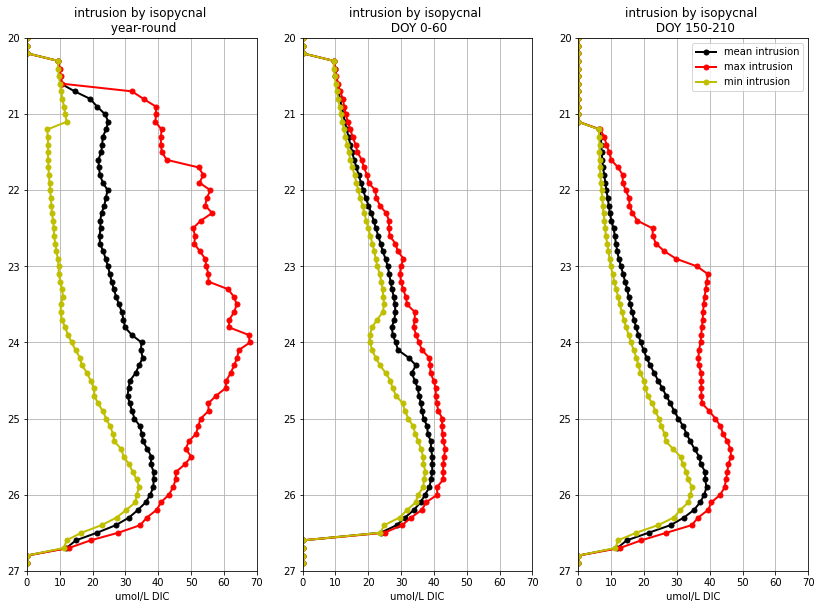

In [107]:
fig, axs = plt.subplots(1,3, figsize=(20*fact, 14*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

q = axs[0].plot(mean_int_yearround,sigmabands, marker = 'o', \
         linestyle = '-', linewidth = 2, color = 'k',\
         markersize = 5, label = 'mean intrusion')
q = axs[0].plot(max_int_yearround,sigmabands, marker = 'o', \
         linestyle = '-', linewidth = 2, color = 'r',\
         markersize = 5, label = 'max intrusion')
q = axs[0].plot(min_int_yearround,sigmabands, marker = 'o', \
         linestyle = '-', linewidth = 2, color = 'y',\
         markersize = 5, label = 'min intrusion')
axs[0].set_title('intrusion by isopycnal \n year-round')

q = axs[1].plot(mean_int_first60,sigmabands, marker = 'o', \
         linestyle = '-', linewidth = 2, color = 'k',\
         markersize = 5, label = 'mean intrusion')
q = axs[1].plot(max_int_first60,sigmabands, marker = 'o', \
         linestyle = '-', linewidth = 2, color = 'r',\
         markersize = 5, label = 'max intrusion')
q = axs[1].plot(min_int_first60,sigmabands, marker = 'o', \
         linestyle = '-', linewidth = 2, color = 'y',\
         markersize = 5, label = 'min intrusion')
axs[1].set_title('intrusion by isopycnal \n DOY 0-60')

q = axs[2].plot(mean_int_150_210,sigmabands, marker = 'o', \
         linestyle = '-', linewidth = 2, color = 'k',\
         markersize = 5, label = 'mean intrusion')
q = axs[2].plot(max_int_150_210,sigmabands, marker = 'o', \
         linestyle = '-', linewidth = 2, color = 'r',\
         markersize = 5, label = 'max intrusion')
q = axs[2].plot(min_int_150_210,sigmabands, marker = 'o', \
         linestyle = '-', linewidth = 2, color = 'y',\
         markersize = 5, label = 'min intrusion')
axs[2].set_title('intrusion by isopycnal \n DOY 150-210')
for i in range(0,3):
    axs[i].grid();
    axs[i].set_ylim([20,27])
    axs[i].invert_yaxis()
    axs[i].set_xlim([0,70])
    axs[i].set_xlabel('umol/L DIC')
    
axs[2].legend(loc = 'best')

In [108]:
print('isopycnals where intrusion >67 umol/L')
newPI_sigma0[np.where(intrusion > 67)]

isopycnals where intrusion >67 umol/L


array([23.97418213, 23.98929405, 23.99515343, 23.9857235 , 24.00083351,
       24.00152397, 23.99207306, 23.99619293, 24.00691414, 24.00576019,
       24.00469971, 24.00637245, 23.99763489, 24.00157356, 24.0100975 ,
       24.00914001, 24.01063728, 24.00237846, 24.00599289, 24.00691223,
       24.01419258, 24.01465607, 24.00692558, 24.01009369, 24.01101303,
       24.01802444, 24.01840973, 24.01203918, 24.01460075, 24.01566124,
       24.0181942 , 24.02017403, 24.02134705, 24.02640533, 24.02778435,
       24.03600693])